In [2]:
import numpy as np

data = np.loadtxt('train_data.txt', delimiter=' ')  # 假设空格分隔
x1 = data[:, 0]  # 第一列
x2 = data[:, 1]  # 第二列
U = data[:, 2]   # 第三列

In [3]:
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0

x1_normalized = (x1 - x1_min) / (x1_max - x1_min)
x2_normalized = (x2 - x2_min) / (x2_max - x2_min)
X = np.stack([x1_normalized, x2_normalized], axis=1)  # 形状 [500, 2]
y = U  # 形状 [500]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [6]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

model = MLP()

In [7]:
criterion = nn.L1Loss()  # L1 Loss 对应 MAE

In [8]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, patience=50):
    best_val_mae = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')
        
        # 早停
        if val_loss < best_val_mae:
            best_val_mae = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # 加载最佳模型
    model.load_state_dict(best_model_state)
    return model, best_val_mae

# 训练模型
model, train_U_mae = train_model(model, train_loader, val_loader, criterion, optimizer)
print(f"训练集最终 MAE: {train_U_mae:.4f}")

Epoch 1/1000, Train MAE: 3.7028, Val MAE: 3.4511
Epoch 2/1000, Train MAE: 3.6561, Val MAE: 3.3886
Epoch 3/1000, Train MAE: 3.5950, Val MAE: 3.3226
Epoch 4/1000, Train MAE: 3.5273, Val MAE: 3.2467
Epoch 5/1000, Train MAE: 3.4406, Val MAE: 3.1651
Epoch 6/1000, Train MAE: 3.3508, Val MAE: 3.0936
Epoch 7/1000, Train MAE: 3.2538, Val MAE: 3.0161
Epoch 8/1000, Train MAE: 3.1435, Val MAE: 2.9420
Epoch 9/1000, Train MAE: 3.0242, Val MAE: 2.8649
Epoch 10/1000, Train MAE: 2.9121, Val MAE: 2.7744
Epoch 11/1000, Train MAE: 2.7966, Val MAE: 2.6767
Epoch 12/1000, Train MAE: 2.6721, Val MAE: 2.5790
Epoch 13/1000, Train MAE: 2.5499, Val MAE: 2.4837
Epoch 14/1000, Train MAE: 2.4222, Val MAE: 2.3710
Epoch 15/1000, Train MAE: 2.2925, Val MAE: 2.2565
Epoch 16/1000, Train MAE: 2.1900, Val MAE: 2.1433
Epoch 17/1000, Train MAE: 2.1042, Val MAE: 2.0356
Epoch 18/1000, Train MAE: 2.0183, Val MAE: 1.9325
Epoch 19/1000, Train MAE: 1.9476, Val MAE: 1.8467
Epoch 20/1000, Train MAE: 1.8642, Val MAE: 1.7601
Epoch 21/

In [10]:
torch.save(model.state_dict(), 'model_demo2.pth')

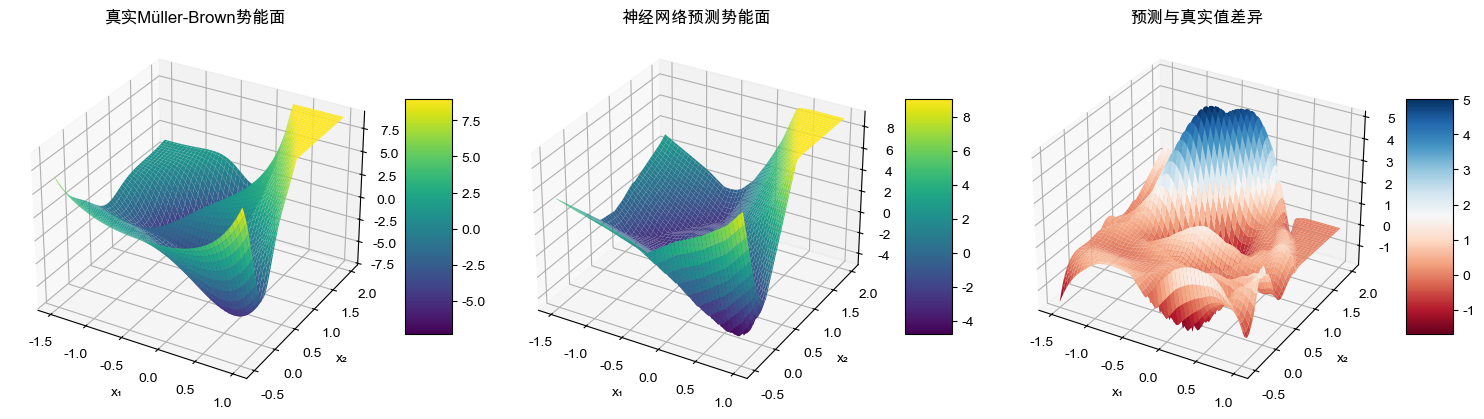

In [14]:
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS系统
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 定义Müller-Brown势能函数
def muller_brown(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    s = 0.05
    A = np.array([-200, -100, -170, 15], dtype=np.float32)
    alpha = np.array([-1, -1, -6.5, 0.7], dtype=np.float32)
    beta = np.array([0, 0, 11, 0.6], dtype=np.float32)
    gamma = np.array([-10, -10, -6.5, 0.7], dtype=np.float32)
    a = np.array([1, 0, -0.5, -1], dtype=np.float32)
    b = np.array([0, 0.5, 1.5, 1], dtype=np.float32)

    x1 = np.asarray(x1, dtype=np.float32)
    x2 = np.asarray(x2, dtype=np.float32)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)

    dx1 = x1 - a
    dx2 = x2 - b

    exponents = alpha * dx1**2 + beta * dx1 * dx2 + gamma * dx2**2

    U = s * np.sum(A * np.exp(exponents), axis=1)

    return np.minimum(U, 9.0)

# 创建网格点
x1 = np.linspace(-1.5, 1.0, 100)
x2 = np.linspace(-0.5, 2.0, 100)
X1, X2 = np.meshgrid(x1, x2)

# 计算真实势能面
U_true = muller_brown(X1.flatten(), X2.flatten()).reshape(X1.shape)

# 计算模型预测的势能面
model.eval()
with torch.no_grad():
    X_grid = np.stack([X1.flatten(), X2.flatten()], axis=1)
    X_grid_normalized = (X_grid - np.array([x1_min, x2_min])) / np.array([x1_max - x1_min, x2_max - x2_min])
    X_grid_tensor = torch.tensor(X_grid_normalized, dtype=torch.float32)
    U_pred = model(X_grid_tensor).numpy().reshape(X1.shape)

# 计算差异
U_diff = U_pred - U_true

# 创建子图
fig = plt.figure(figsize=(15, 5))

# 第一张图：真实势能面
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X1, X2, U_true, cmap='viridis', linewidth=0)
ax1.set_title('真实Müller-Brown势能面')
ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_zlabel('U')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# 第二张图：模型预测势能面
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X1, X2, U_pred, cmap='viridis', linewidth=0)
ax2.set_title('神经网络预测势能面')
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.set_zlabel('U')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

# 第三张图：差异分布
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X1, X2, U_diff, cmap='RdBu', linewidth=0)
ax3.set_title('预测与真实值差异')
ax3.set_xlabel('x₁')
ax3.set_ylabel('x₂')
ax3.set_zlabel('ΔU')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

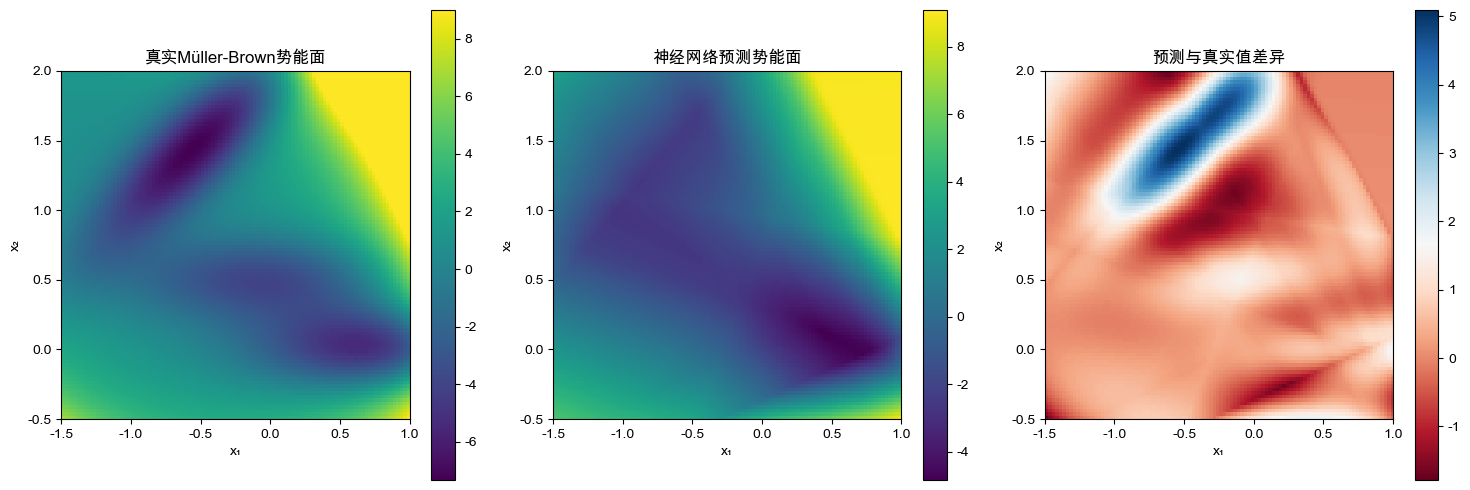

In [15]:
# 创建2D热图
fig = plt.figure(figsize=(15, 5))

# 第一张图：真实势能面
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(U_true, extent=[x1[0], x1[-1], x2[0], x2[-1]], origin='lower', cmap='viridis')
ax1.set_title('真实Müller-Brown势能面')
ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
fig.colorbar(im1, ax=ax1)

# 第二张图：模型预测势能面
ax2 = fig.add_subplot(132)
im2 = ax2.imshow(U_pred, extent=[x1[0], x1[-1], x2[0], x2[-1]], origin='lower', cmap='viridis')
ax2.set_title('神经网络预测势能面')
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
fig.colorbar(im2, ax=ax2)

# 第三张图：差异分布
ax3 = fig.add_subplot(133)
im3 = ax3.imshow(U_diff, extent=[x1[0], x1[-1], x2[0], x2[-1]], origin='lower', cmap='RdBu')
ax3.set_title('预测与真实值差异')
ax3.set_xlabel('x₁')
ax3.set_ylabel('x₂')
fig.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()